# Bayes by Backprop with ``gluon`` (NN, classification)

After discussing [Bayes by Backprop from scratch](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.ipynb) in a previous notebook, we can now look at the corresponding implementation as ``gluon`` components.

We start off with the usual set of imports.

In [3]:
from __future__ import print_function
import collections
import mxnet as mx
import numpy as np
from mxnet import nd, autograd
from matplotlib import pyplot as plt
from mxnet import gluon

For easy tuning and experimentation, we define a dictionary holding the hyper-parameters of our model.

In [4]:
config = {
    "num_hidden_layers": 2,
    "num_hidden_units": 400, 
    "batch_size": 128,
    "epochs": 10,
    "learning_rate": 0.001,
    "num_samples": 1,
    "pi": 0.25,
    "sigma_p": 1.0,
    "sigma_p1": 0.75,
    "sigma_p2": 0.01,
}

Also, we specify the device context for MXNet.

In [5]:
ctx = mx.cpu()

## Load MNIST data

We will again train and evaluate the algorithm on the MNIST data set and therefore load the data set as follows:

In [6]:
def transform(data, label):
    return data.astype(np.float32)/126.0, label.astype(np.float32)

mnist = mx.test_utils.get_mnist()
num_inputs = 784
num_outputs = 10
batch_size = config['batch_size']

train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                                     batch_size, shuffle=False)

num_train = sum([batch_size for i in train_data])
num_batches = num_train / batch_size

In order to reproduce and compare the results from the paper, we preprocess the pixels by dividing by 126.

## Model definition

We can construct a few new Bayes gluon components that will facilitate our model training,

In [73]:
class BayesDense(gluon.nn.Dense):
    def __init__(self, *args, weight_std_initializer=None, bias_std_initializer='zeros', **kwargs):
        super(BayesDense, self).__init__(*args, **kwargs)
        with self.name_scope():
            self.weight_std = self.params.get('weight_std', shape=(self._units, self._in_units),
                                              init=weight_std_initializer,
                                              allow_deferred_init=True)
            if self.bias is not None:
                self.bias_std = self.params.get('bias_std', shape=(self._units,),
                                                init=bias_std_initializer,
                                                allow_deferred_init=True)
            else:
                self.bias_std = None
    
    def get_shapes(self, weight_std, bias_std):
        if not hasattr(weight_std, 'shape'):
            r_shape = (self._units, self._in_units)
        else:
            r_shape = self.weight_std.shape
        return r_shape, (self._units,)
    
    def bayes_loss(self, F, weight_std, bias_std=None, **kwargs):
        """
        Computes the extra terms in the Bayes loss function
        """
        rw_shape, rb_shape = self.get_shapes(weight_std, bias_std)
        
        loss = -F.log(weight_std) - F.random_normal(shape=rw_shape)**2/(2.0 * weight_std**2)
        if bias_std is not None:
            loss = loss - F.log(bias_std) - F.random_normal(shape=rb_shape)/(2.0 * bias_std**2)
        return loss
    
    def hybrid_forward(self, F, x, weight, weight_std, bias=None, bias_std=None):
        rw_shape, rb_shape = self.get_shapes(self.weight_std, self.bias_std)
        
        w = weight + F.random_normal(shape=rw_shape) * weight_std
        if bias is not None:
            b = bias + F.random_normal(shape=rb_shape) * bias_std
        return super(BayesDense, self).hybrid_forward(F, x, weight=w, bias=b)

class BayesSequential(gluon.nn.HybridSequential):
    def bayes_loss(self, F, **kwargs):
        return sum(
            c.bayes_loss(F, **{i: j.var() for i, j in c._reg_params.items()}, **kwargs) 
            if type(c) == BayesDense else 0.0
            for c in self._children
        )
    
class BayesSoftmaxCrossEntropyLoss(gluon.loss.SoftmaxCrossEntropyLoss):
    def __init__(self, bayes_net, *args, **kwargs):
        assert hasattr(bayes_net, 'bayes_loss')
        super(BayesSoftmaxCrossEntropyLoss, self).__init__(*args, **kwargs)
        with self.name_scope():
            self.bayes_net = bayes_net
        
    def hybrid_forward(self, F, *args, **kwargs):
        return (
            super(BayesSoftmaxCrossEntropyLoss, self).hybrid_forward(F, *args, **kwargs) +
            self.bayes_net.bayes_loss(F)
        )

### Neural net modeling

As our model we are using a straightforward MLP and we are wiring up our network just as we are used to in ``gluon``. Note that we are not using any special layers during the definition of our network, as we believe that Bayes by Backprop should be thought of as a training method, rather than a speical architecture.

In [74]:
num_layers = config['num_hidden_layers']
num_hidden = config['num_hidden_units']

net = BayesSequential()
with net.name_scope():
    for i in range(num_layers):
        net.add(BayesDense(num_hidden, activation="relu"))
    net.add(BayesDense(num_outputs))

## Build objective/loss

Again, we define our loss function as described in [Bayes by Backprop from scratch](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.ipynb). Note that we are bundling all of this functionality as part of a ``gluon.loss.Loss`` subclass, where the loss computation is performed in the ``hybrid_forward`` function.

## Parameter initialization

First, we need to initialize all the network's parameters, which are only point estimates of the weights at this point. We will soon see, how we can still train the netork in a Bayesian fashion, without interfering with the netowk's architecture.

In [75]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
softmax_cross_entropy = BayesSoftmaxCrossEntropyLoss(net)

Then we have to forward-propagate a single data set entry once to set up all network parameters (weights and biases) with the desired initliaizer specified above.

## Optimizer

Now, we still have to choose the optimizer we wish to use for training. This time, we are using the ``adam`` optimizer.

In [76]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': config['learning_rate']})

## Main training loop



### Complete loop

The complete training loop is given below.

In [77]:
epochs = config['epochs']
learning_rate = config['learning_rate']
smoothing_constant = .01
train_acc = []
test_acc = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data): 
        data = data.as_in_context(ctx).reshape((-1, 784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
            loss.backward()
        trainer.step(data.shape[0])
        
        # calculate moving loss for monitoring convergence
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0)) 
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
    
    test_accuracy = evaluate_accuracy(test_data, net, raw_mus)
    train_accuracy = evaluate_accuracy(train_data, net, raw_mus)
    train_acc.append(np.asscalar(train_accuracy))
    test_acc.append(np.asscalar(test_accuracy))
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, moving_loss, train_accuracy, test_accuracy))
    
plt.plot(train_acc)
plt.plot(test_acc)
plt.show()

AssertionError: Argument data must have NDArray type, but got <Symbol bayessequential22_bayesdense0_weight_std>

For demonstration purposes, we can now take a look at one particular weight by plotting its distribution.

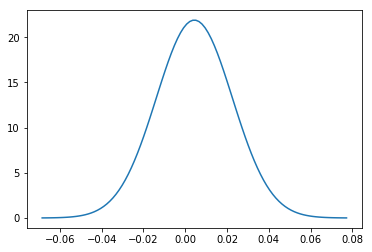

In [17]:
def gaussian(x, mu, sigma):
    scaling = 1.0 / nd.sqrt(2.0 * np.pi * (sigma ** 2))
    bell = nd.exp(- (x - mu) ** 2 / (2.0 * sigma ** 2))

    return scaling * bell

def show_weight_dist(mean, variance):
    sigma = nd.sqrt(variance)
    x = np.linspace(mean.asscalar() - 4*sigma.asscalar(), mean.asscalar() + 4*sigma.asscalar(), 100)
    plt.plot(x, gaussian(nd.array(x, ctx=ctx), mean, sigma).asnumpy())
    plt.show()
    
mu = raw_mus[0][0][0]
var = softplus(raw_rhos[0][0][0]) ** 2

show_weight_dist(mu, var)

## Weight pruning

To measure the degree of redundancy present in the trained network and to reduce the model's parameter count, we now want to examine the effect of setting some of the weights to $0$ and evaluate the test accuracy afterwards. We can achieve this by ordering the weights according to their signal-to-noise-ratio, $\frac{|\mu_i|}{\sigma_i}$, and setting a certain percentage of the weights with the lowest ratios to $0$.

We can calculate the signal-to-noise-ratio as follows:

In [18]:
def signal_to_noise_ratio(mus, sigmas):
    sign_to_noise = []
    for j in range(len(mus)):
        sign_to_noise.extend([nd.abs(mus[j]) / sigmas[j]])
    return sign_to_noise

We further introduce a few helper methods which turn our list of weights into a single vector containing all weights. This will make our subsequent actions easier.

In [19]:
def vectorize_matrices_in_vector(vec):
    for i in range(0, (num_layers + 1) * 2, 2):
        if i == 0:
            vec[i] = nd.reshape(vec[i], num_inputs * num_hidden)
        elif i == num_layers * 2:
            vec[i] = nd.reshape(vec[i], num_hidden * num_outputs)
        else:
            vec[i] = nd.reshape(vec[i], num_hidden * num_hidden)
            
    return vec

def concact_vectors_in_vector(vec):
    concat_vec = vec[0]
    for i in range(1, len(vec)):
        concat_vec = nd.concat(concat_vec, vec[i], dim=0)
    
    return concat_vec

def transform_vector_structure(vec):
    vec = vectorize_matrices_in_vector(vec)
    vec = concact_vectors_in_vector(vec)
    
    return vec

In addition, we also have a helper method which transforms the pruned weight vector back to the original layered structure.

In [20]:
from functools import reduce
import operator

def prod(iterable):
    return reduce(operator.mul, iterable, 1)

def restore_weight_structure(vec):
    pruned_weights = []
    
    index = 0
    
    for shape in shapes:
        incr = prod(shape)
        pruned_weights.extend([nd.reshape(vec[index : index + incr], shape)])
        index += incr
    
    return pruned_weights

The actual pruning of the vector happens in the following function. Note that this function accepts an ordered list of percentages to evaluate the performance at different pruning rates. In this setting, pruning at each iteration means extracting the index of the lowest signal-to-noise-ratio weight and setting the weight at this index to $0$.

In [21]:
def prune_weights(sign_to_noise_vec, prediction_vector, percentages):
    pruning_indices = nd.argsort(sign_to_noise_vec, axis=0)
    
    for percentage in percentages:
        prediction_vector = mus_copy_vec.copy()
        pruning_indices_percent = pruning_indices[0:int(len(pruning_indices)*percentage)]
        for pr_ind in pruning_indices_percent:
            prediction_vector[int(pr_ind.asscalar())] = 0
        pruned_weights = restore_weight_structure(prediction_vector)
        test_accuracy = evaluate_accuracy(test_data, net, pruned_weights)
        print("%s --> %s" % (percentage, test_accuracy))

Putting the above function together:

In [22]:
sign_to_noise = signal_to_noise_ratio(raw_mus, sigmas)
sign_to_noise_vec = transform_vector_structure(sign_to_noise)

mus_copy = raw_mus.copy()
mus_copy_vec = transform_vector_structure(mus_copy)

prune_weights(sign_to_noise_vec, mus_copy_vec, [0.1, 0.25, 0.5, 0.75, 0.95, 0.98, 1.0])

0.1 --> 0.9737
0.25 --> 0.9737
0.5 --> 0.9748
0.75 --> 0.9754
0.95 --> 0.9697
0.98 --> 0.9549
1.0 --> 0.098


Depending on the number of units used in the original network, the highest achievable pruning percentages (without significantly reducing the predictive performance) can vary. The paper, for example, reports almost no change in the test accuracy when pruning 95% of the weights in a 1200 unit Bayesian neural network, which creates a significantly sparser network, leading to faster predictions and reduced memory requirements.

## Conclusion

We have taken a look at an efficient Bayesian treatment for neural networks using variational inference via the "Bayes by Backprop" algorithm (introduced by the "[Weight Uncertainity in Neural Networks](https://arxiv.org/abs/1505.05424)" paper). We have implemented a stochastic version of the variational lower bound and optimized it in order to find an approximation to the posterior distribution over the weights of a MLP network on the MNIST data set. As a result, we achieve regularization on the network's parameters and can quantify our uncertainty about the weights accurately. Finally, we saw that it is possible to significantly reduce the number of weights in the neural network after training while still keeping a high accuracy on the test set.

We also note that, given this model implementation, we were able to reproduce the paper's results on the MNIST data set, achieving a comparable test accuracy for all documented instances of the MNIST classification problem.

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)